In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [18]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def lower_case(data):
    data['word'] = data['word'].astype(str).apply(lambda x: x.lower())

def drop_rows_with_stopwords(df):
    def row_has_stopword(row):
        for col in df.columns:
            words = str(row[col]).split()
            if any(word in stop_words for word in words):
                return True
        return False

    mask = df.apply(row_has_stopword, axis=1)
    df.drop(df[mask].index, inplace=True)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
def load_data(file_path):

    data = pd.read_csv(file_path, header=None, names=['sentence'])
    data['sentence'] = data['sentence'].apply(ast.literal_eval)

    processed = []
    for sentence in data['sentence']:
        for word, tag in sentence:
            processed.append((word, tag))

    return pd.DataFrame(processed, columns=['word', 'tag'])

def preprocess_data(data):
    data = data.dropna(subset=['tag'])
    words = list(set(data['word']))
    tags = list(set(data['tag']))
    word_to_idx = {w: i for i, w in enumerate(words)}
    tag_to_idx = {t: i for i, t in enumerate(tags)}
    return word_to_idx, tag_to_idx, words, tags

def estimate_hmm_parameters(data, word_to_idx, tag_to_idx):
    num_tags = len(tag_to_idx)
    num_words = len(word_to_idx)
    transition = np.ones((num_tags, num_tags))
    emission = np.ones((num_tags, num_words))
    initial = np.ones(num_tags)

    prev = None
    for _, row in data.iterrows():
        w_idx = word_to_idx[row['word']]
        t_idx = tag_to_idx[row['tag']]
        emission[t_idx, w_idx] += 1

        if prev is not None:
            transition[prev, t_idx] += 1
        else:
            initial[t_idx] += 1
        prev = t_idx

    emission = np.log(emission / emission.sum(axis=1, keepdims=True))
    transition = np.log(transition / transition.sum(axis=1, keepdims=True))
    initial = np.log(initial / initial.sum())

    return emission, transition, initial

def viterbi(sentence, word_to_idx, tag_to_idx, emission, transition, initial):
    if not sentence:
        return []

    sent_indices = [word_to_idx.get(w, -1) for w in sentence]
    num_tags = len(tag_to_idx)
    num_words = len(sentence)

    if all(i == -1 for i in sent_indices):
        common_tag = np.argmax(np.sum(np.exp(emission), axis=1))
        idx_to_tag = {v: k for k, v in tag_to_idx.items()}
        return [idx_to_tag[common_tag]] * len(sentence)

    viterbi_matrix = np.full((num_tags, num_words), -np.inf)
    backpointer = np.zeros((num_tags, num_words), dtype=int)

    for t in range(num_tags):
        w_idx = sent_indices[0]
        viterbi_matrix[t, 0] = initial[t] + (emission[t, w_idx] if w_idx != -1 else np.log(1e-10))
        backpointer[t, 0] = -1

    for i in range(1, num_words):
        for t in range(num_tags):
            w_idx = sent_indices[i]
            probs = viterbi_matrix[:, i-1] + transition[:, t] + (emission[t, w_idx] if w_idx != -1 else np.log(1e-10))
            viterbi_matrix[t, i] = np.max(probs)
            backpointer[t, i] = np.argmax(probs)

    best_tag = np.argmax(viterbi_matrix[:, -1])
    best_path = [best_tag]

    for i in range(num_words - 1, 0, -1):
        best_tag = backpointer[best_tag, i]
        best_path.insert(0, best_tag)

    idx_to_tag = {v: k for k, v in tag_to_idx.items()}
    return [idx_to_tag[idx] for idx in best_path]

def evaluate_model(test_data, word_to_idx, tag_to_idx, emission, transition, initial):
    correct, total = 0, 0
    predicted_tags, actual_tags = [], []
    sentences, current = [], []

    for _, row in test_data.iterrows():
        if row['word'] == '.' and row['tag'] == '.':
            sentences.append(current)
            current = []
        else:
            current.append((row['word'], row['tag']))

    for sentence in sentences:
        words = [w for w, _ in sentence]
        actual = [t for _, t in sentence]

        if not words:
            continue

        predicted = viterbi(words, word_to_idx, tag_to_idx, emission, transition, initial)
        predicted_tags.extend(predicted)
        actual_tags.extend(actual)

        for p, a in zip(predicted, actual):
            if p == a:
                correct += 1
            total += 1

    return correct / total if total > 0 else 0, predicted_tags, actual_tags


before cleaning:
<bound method NDFrame.head of                word    tag
0                DF  PROPN
1        03/01/2001    NUM
2             01:35    NUM
3                PM   NOUN
4               The    DET
...             ...    ...
1056968           .  PUNCT
1056969           B    ADJ
1056970           &  CCONJ
1056971           w    ADJ
1056972           .  PUNCT

[1056973 rows x 2 columns]>
<bound method NDFrame.head of                word    tag
0                DF  PROPN
1        03/01/2001    NUM
2             01:35    NUM
3                PM   NOUN
4               The    DET
...             ...    ...
1318470         has   VERB
1318471         not    ADV
1318472         had   VERB
1318473        them   PRON
1318474           .      .

[1318475 rows x 2 columns]>
after cleaning:
<bound method NDFrame.head of                word    tag
0                df  PROPN
1        03/01/2001    NUM
2             01:35    NUM
3                pm   NOUN
5          industry   NOUN
...      

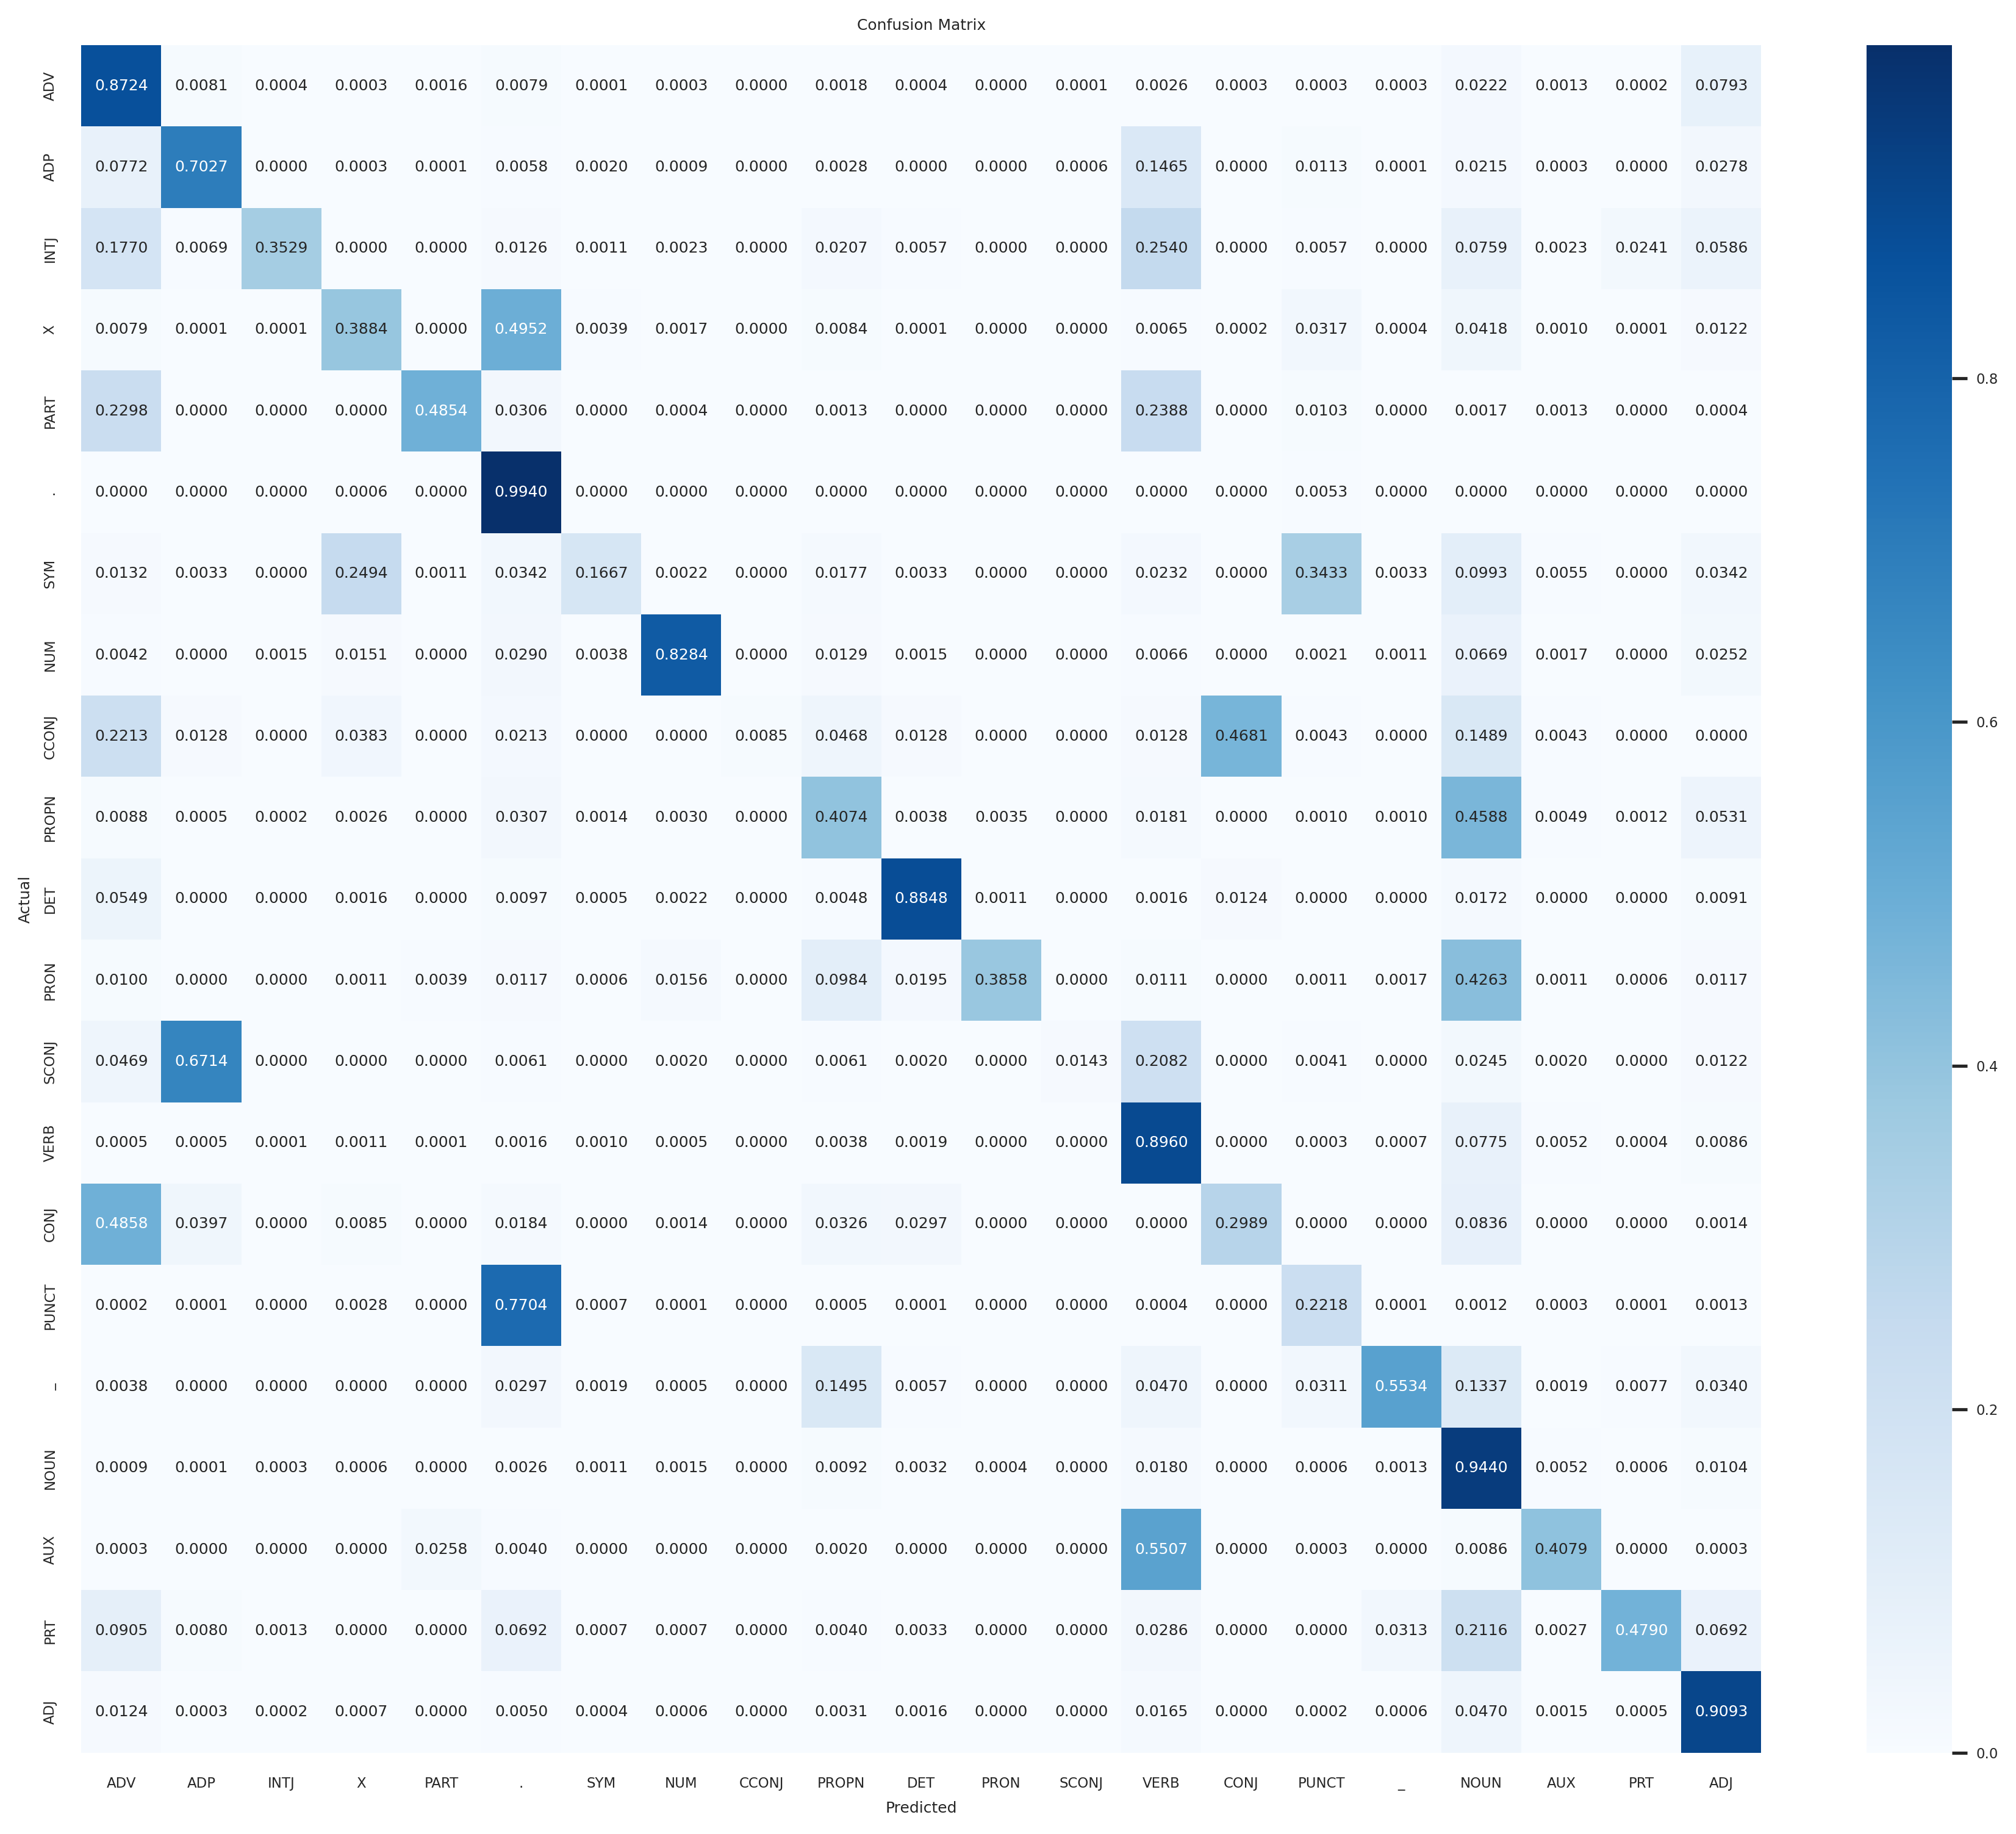

In [23]:
def main():
    train_data = load_data('TRAIN.csv')
    test_data = load_data('TEST.csv')
    print("before cleaning:")
    print(train_data.head)
    print(test_data.head)
    lower_case(train_data)
    lower_case(test_data)
    drop_rows_with_stopwords(train_data)
    drop_rows_with_stopwords(test_data)
    train_data = train_data.dropna(subset=['word'])
    test_data = test_data.dropna(subset=['word'])
    print("after cleaning:")
    print(train_data.head)
    print(test_data.head)

    word_to_idx, tag_to_idx, words, tags = preprocess_data(train_data)
    emission, transition, initial = estimate_hmm_parameters(train_data, word_to_idx, tag_to_idx)

    accuracy, predicted_tags, actual_tags = evaluate_model(test_data, word_to_idx, tag_to_idx, emission, transition, initial)
    print(f"Model Accuracy: {accuracy:.4f}")

    plt.figure(figsize=(12, 10), dpi=300)
    cm = confusion_matrix(actual_tags, predicted_tags, labels=tags, normalize='true')
    sns.heatmap(cm, annot=True, fmt='.4f', cmap='Blues', xticklabels=tags, yticklabels=tags)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

if __name__ == "__main__":
    main()